In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import os
from torchsummary import summary
from sklearn.decomposition import PCA

seed =2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
gpu_id = 0
device = torch.device(device, gpu_id)

if device =='cuda : 0':
    torch.cuda.manual_seed(seed)

np.random.seed(seed)
torch.manual_seed(seed)


cpu


In [3]:
#データの取り込み
data_narray = np.load("image_states.npy")
print("original_data.shape = {}".format(data_narray.shape))

#cnn入力用にreshapeする
data_input = np.reshape(data_narray, (-1, 3, 24, 32))
print("input_data.shape = {}".format(data_input.shape))
print(np.max(data_input))
print(np.min(data_input))

original_data.shape = (100, 160, 24, 32, 3)
input_data.shape = (16000, 3, 24, 32)
1.0
0.0


In [4]:
#@title データ定義
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, input_data):
        self.input_data = torch.from_numpy(input_data).float()

    def __len__(self):
        return self.input_data.shape[0]

    def __getitem__(self, idx):
        input_datum = self.input_data[idx]#+torch.normal(mean=0, std = 1, size=self.input_data[idx].shape)<-入力0-1の外の値も入力してしまう
        return input_datum

def create_dataloader(batch_size, input_data):

    indeces = [int(input_data.shape[0] * n) for n in [0.4, 0.4+0.1, 0.9]]
    train_data1, val_data1, train_data2, val_data2 = np.split(input_data, indeces, axis=0)
    train_data = np.concatenate([train_data1, train_data2], axis=0)
    val_data = np.concatenate([val_data1, val_data2], axis=0)

    train_dataset = MyDataset(train_data)
    val_dataset = MyDataset(val_data)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_dataloader, val_dataloader

def visualize_loss(epochs, dict_eachLoss, fig_name):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(dict_eachLoss['train_recon'], linestyle="solid")
    ax.plot(dict_eachLoss['train_kl'], linestyle="dashed")
    ax.plot(dict_eachLoss['train_loss'], linestyle = "dotted")
    ax.plot(dict_eachLoss['val_recon'], linestyle="solid")
    ax.plot(dict_eachLoss['val_kl'], linestyle="dashed")
    ax.plot(dict_eachLoss['val_loss'], linestyle = "dotted")
    ax.set_yscale('log')
    ax.legend(['train_recon_loss * weight_lamda', 'train_kld', 'train_loss', 'val_recon * weight_lamda', 'val_kld', 'val_loss'],\
              loc='center left', bbox_to_anchor=(1., .5))
    

    ax.set_xlim(0, epochs)
    ax.set_title('each_loss')
    fig.savefig(fig_name + ".png")


    {'train_loss' : [], 'train_recon' : [], 'train_kl' : [], 'val_loss' : [], 'val_recon' : [], 'val_kl' : [],}

In [5]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=100, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [6]:
#@title モデル定義
# x -> (encoder) -> z_latent -> (decoder) -> y
#method : forward, reparameterize, cal_loss
class VAE_BCE(nn.Module):
    def __init__(self, z_dim,device):
        super(VAE_BCE, self).__init__()
        self.device = device
        self.encoder = VAE_Encoder(z_dim)
        self.decoder = VAE_Decoder(z_dim)
        self.z_dim = z_dim

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        y = self.decoder(z)
        return y, z

    def reparameterize(self, mean, var):
        z = (mean + torch.mul(torch.sqrt(torch.exp(var)), torch.normal(mean = 0, std=1, size=mean.shape).to(self.device)))
        return z

    def cal_loss(self, x, criterion = nn.BCELoss()):
        
        mean, log_var = self.encoder.forward(x)
        #print("var{}".format(var))
        z = self.reparameterize(mean, log_var)
        y = self.decoder.forward(z)
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        #変分下限Lの最大化　-> -Lの最小化
        reconstruction = criterion(y , x)
        kl = -torch.sum(1+log_var- mean**2 - torch.exp(log_var))/2
        #print("reconstruction : {}".format(reconstruction.shape))
        #print("KL : {}".format(kl.shape))
        loss = reconstruction + kl
        return loss, reconstruction, kl 

class VAE_MSE(nn.Module):
    def __init__(self, z_dim,device):
        super(VAE_MSE, self).__init__()
        self.device = device
        self.encoder = VAE_Encoder(z_dim)
        self.decoder = VAE_Decoder(z_dim)
        self.z_dim = z_dim
        self.beta = 1
        self.var = 1e-2

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        y = self.decoder(z)
        return z, y

    def reparameterize(self, mean, var):
        z = (mean + torch.mul(torch.sqrt(torch.exp(var)), torch.normal(mean = 0, std=1, size=mean.shape).to(self.device)))
        return z

    def cal_loss(self, x, criterion = nn.MSELoss()):
        scale_adjust = x.shape[1] * x.shape[2] *x.shape[3]/ self.z_dim
        mean, log_var = self.encoder.forward(x)
        #print("var{}".format(var))
        z = self.reparameterize(mean, log_var)
        y = self.decoder.forward(z)
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        #変分下限Lの最大化　-> -Lの最小化
        reconstruction = criterion(y , x) * scale_adjust/(self.var*2)
        kl = -torch.mean(1+log_var- mean**2 - torch.exp(log_var))/2#beta_vae
        #print("reconstruction : {}".format(reconstruction.shape))
        #print("KL : {}".format(kl.shape))
        loss =  reconstruction + kl
        return loss, reconstruction, kl 


class VAE_Encoder(nn.Module):
    def __init__(self, z_dim):
        super(VAE_Encoder, self).__init__()
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = 8),
            nn.Mish(),
            
        )#->(8, 24, 32)

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.Mish(),
            
        )#->(8, 12, 16)

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(in_channels =16, out_channels=32, kernel_size=3, stride=2,),
            nn.BatchNorm2d(num_features=32),
            nn.Mish(),
            
        )#->(16, 5, 7)
        
        self.mean_layer = nn.Sequential(
            nn.Linear(32*5*7, 200),
            nn.Mish(),
            nn.BatchNorm1d(num_features=200),
            nn.Linear(200, z_dim)    
        )   
        self.log_var_layer = nn.Sequential(
            nn.Linear(32*5*7, 150),
            nn.Mish(),
            nn.BatchNorm1d(num_features=150),
            nn.Linear(150, z_dim)
            
        )   

    def forward(self, x):
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = self.cnn_layer3(out)
        out = out.view(out.size(0), -1)

        mean = self.mean_layer(out)
        log_var = self.log_var_layer(out)

        return mean, log_var

class VAE_Decoder(nn.Module):
    def __init__(self, z_dim):
        super(VAE_Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, 100)
        self.fc2 = nn.Linear(100, 32*3*4)

        self.cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 16),
            nn.Mish(),
            
        )#->(8, 7, 9)

        self.cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(num_features = 8),
            nn.Mish(),
            
        )#->(8, 13, 17)

        self.cnn_layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=4, stride=2, padding=1),
        )#->(3, 24, 32)


    def forward(self, z):
        out = self.fc1(z)
        out = torch.relu(out)
        #out = nn.BatchNorm1d(num_features=40)(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = out.view(-1, 32, 3, 4)
        out = self.cnn_layer1(out)
        out = self.cnn_layer2(out)
        out = self.cnn_layer3(out)
        out = torch.sigmoid(out)
        
        return out
        




In [7]:
# earlyStopping、datalaoder
def train(model, optimizer, epochs, batch_size, lr, data_input, loss_fig_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_dataloader, val_dataloader = create_dataloader(batch_size, data_input)
    torch.manual_seed(seed=seed)
    optimizer = optimizer(model.parameters(), lr=lr)
    early_stopping = EarlyStopping()

    #勾配クリッピング
    #grad_clip = 1

    loss_dict = {'train_loss' : [], 'train_recon' : [], 'train_kl' : [], 'val_loss' : [], 'val_recon' : [], 'val_kl' : [],}

    for epoch in range(epochs):
        train_loss = 0
        train_reconstruction = 0
        train_kld = 0

        for inputs in train_dataloader:

            model.train()
            inputs = inputs.to(device)
            loss, _, _ = model.cal_loss(inputs)
            #print("loss.shpe {}".format(loss.shape))

            optimizer.zero_grad()
            loss.backward()
            #nn.utils.clip_grad_value_(parameters=model.parameters(), clip_value=grad_clip)
            optimizer.step()    

            model.eval()
            with torch.no_grad():
                each_train_loss, train_recon, train_kl = model.cal_loss(inputs)
                train_loss += each_train_loss.item()
                train_reconstruction += train_recon.item()
                train_kld += train_kl.item()

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_reconstruction = 0
            val_kld = 0
            for inputs in val_dataloader:
                inputs = inputs.to(device)
                each_val_loss, val_recon, val_kl = model.cal_loss(inputs)
                val_loss += each_val_loss.item()
                val_reconstruction += val_recon.item()
                val_kld += val_kl.item()


        print("Epoch: {}/{} ".format(epoch + 1, epochs),
            "Traning Loss: {} ".format(train_loss/len(train_dataloader)),
            "Train_Reconstruction: {} ".format(train_reconstruction/len(train_dataloader)),
            "Train_KL: {} ".format(train_kld/len(train_dataloader)),
            "Validation Loss : {}".format(val_loss/len(val_dataloader)),
            "Val_Reconstruction : {}".format(val_reconstruction/len(val_dataloader)),
            "Val_KL : {}".format(val_kld/len(val_dataloader)))

        loss_dict["train_loss"].append(train_loss/len(train_dataloader))
        loss_dict["train_recon"].append(train_reconstruction/len(train_dataloader))
        loss_dict["train_kl"].append(train_kld/len(train_dataloader))
        loss_dict["val_loss"].append(val_loss/len(val_dataloader))
        loss_dict["val_recon"].append(val_reconstruction/len(val_dataloader))
        loss_dict["val_kl"].append(val_kld/len(val_dataloader))

        if math.isnan(val_loss) and epoch>0:
            break
        
        if epoch > 3000:
            early_stopping(val_loss/len(val_dataloader), model) # 最良モデルならモデルパラメータ保存
            if early_stopping.early_stop: 
                        # 一定epochだけval_lossが最低値を更新しなかった場合、ここに入り学習を終了
                break   

    visualize_loss( epoch,loss_dict,"image/"+loss_fig_name+".png")
    return epoch
    

In [8]:
#x -> (encoder) -> z_latent -> (decoder) -> y
#16000のデータ化から、ランダムにデータxを１０個生成してx,yを比較
def generate_xy_Image(model, data_input, fig_name):
    device = torch.device('cpu')
    data_input = torch.from_numpy(data_input)
    data_input = data_input.to(device)

    inputs, outputs = genrate_random_inputAndReconst(model, data_input)

    #入力xの表示(10個分)
    input_images =inputs.to(device).detach().numpy().copy()
    print("input_image")
    print(input_images.shape)
    print(np.min(input_images))
    print(np.max(input_images))
    for i, image in enumerate(input_images):
        plt.title("original")
        plt.subplot(2, 5, i+1)
        plt.imshow(image.reshape(24, 32, 3))
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("image/inputs"+fig_name+".png")

    #出力yの表示(10個)
    output_images = (outputs).to(device).detach().numpy().copy()
    print("renconst_image")
    print(output_images.shape)
    print(np.min(output_images))
    print(np.max(output_images))
    for i, image in enumerate(output_images):
        plt.title("reconst")
        plt.subplot(2, 5, i+1)
        image = image.reshape(24, 32, 3)
        plt.imshow(image)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("image/recon" + fig_name + ".png")     

def genrate_random_inputAndReconst(model, data_input):
    device = torch.device("cpu")

    #入力データを2で割って学習させたので、画像の生成時には2をかけて元に戻す
    data_input_tensor = data_input.clone()
    inputs = torch.zeros((10, 3, 24, 32))
    outputs = torch.zeros((10, 3, 24, 32))

    #xをランダムに生成
    torch.manual_seed(seed=2)
    random_index = torch.randint(low=0, high=16000, size=(10,))
    for i in range(10):
        input = data_input_tensor[random_index[i]]
        inputs[i] = input
    
    model = model.to(device)
    #yを求める    
    model.eval()
    with torch.no_grad():
        _, outputs = model.forward(inputs.to(device))

    return inputs, outputs    

(16000, 3, 24, 32)
Epoch: 1/5000  Traning Loss: 420.10516357421875  Train_Reconstruction: 420.09854888916016  Train_KL: 0.006609134419704787  Validation Loss : 414.4334716796875 Val_Reconstruction : 414.4193115234375 Val_KL : 0.01416084636002779
Epoch: 2/5000  Traning Loss: 414.4707336425781  Train_Reconstruction: 414.43896865844727  Train_KL: 0.03176386887207627  Validation Loss : 406.1064910888672 Val_Reconstruction : 406.0615234375 Val_KL : 0.04496537335216999
Epoch: 3/5000  Traning Loss: 396.5948600769043  Train_Reconstruction: 396.5274238586426  Train_KL: 0.06744172796607018  Validation Loss : 378.10569763183594 Val_Reconstruction : 378.010498046875 Val_KL : 0.0952029898762703
Epoch: 4/5000  Traning Loss: 354.63475799560547  Train_Reconstruction: 354.4369926452637  Train_KL: 0.1977612730115652  Validation Loss : 327.7830810546875 Val_Reconstruction : 327.4643859863281 Val_KL : 0.3186857998371124
Epoch: 5/5000  Traning Loss: 307.48828887939453  Train_Reconstruction: 306.88430404663

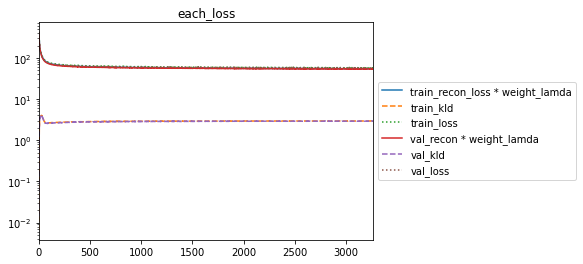

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer1 = torch.optim.Adam
optimizer2 = torch.optim.Adadelta

batch_size = 1600
print(data_input.shape)


epoch = 0

model = VAE_MSE(z_dim =8 , device = device).to(device)
epoch = train(model=model, optimizer=optimizer1, epochs=5000, batch_size = batch_size,\
          lr=0.001, data_input=data_input, loss_fig_name="MSE_z8_earlyfrom3000")
     
path = "/home/igari/igari/VAE_本へ/checkpoint.pt"
model = VAE_MSE(z_dim = 8, device = 'cpu')
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
     
path = "learned_model/epoch5000_z8_earlyfrom3000_weight.pth"
torch.save(model.to('cpu').state_dict(), path)

In [34]:
path = "/home/igari/igari/VAE_本へ/checkpoint.pt"
model = VAE_MSE(z_dim = 4, device = 'cpu')
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
     
path = "learned_model/epoch30000_beta100_earlyfrom2000_Adam_weight.pth"
torch.save(model.to('cpu').state_dict(), path)

In [36]:
#学習済みモデルの読み込み
path = "learned_model/epoch30000_beta100_earlyfrom2000_Adam_weight.pth"
model = VAE_MSE(z_dim = 4, device = 'cpu')
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
#model = torch.load("/content/drive/MyDrive/VAE/model_weight.pth")

<All keys matched successfully>

In [9]:
net = VAE_MSE(z_dim=5, device='cpu').to('cpu')
summary(net, (3, 24, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 24, 32]             224
       BatchNorm2d-2            [-1, 8, 24, 32]              16
              Mish-3            [-1, 8, 24, 32]               0
            Conv2d-4           [-1, 16, 12, 16]           1,168
       BatchNorm2d-5           [-1, 16, 12, 16]              32
              Mish-6           [-1, 16, 12, 16]               0
            Conv2d-7             [-1, 32, 5, 7]           4,640
       BatchNorm2d-8             [-1, 32, 5, 7]              64
              Mish-9             [-1, 32, 5, 7]               0
           Linear-10                  [-1, 200]         224,200
             Mish-11                  [-1, 200]               0
      BatchNorm1d-12                  [-1, 200]             400
           Linear-13                    [-1, 5]           1,005
           Linear-14                  [

input_image
(10, 3, 24, 32)
0.0
1.0
renconst_image
(10, 3, 24, 32)
0.014716987
0.9999982


/home/igari/.local/share/virtualenvs/VAE_本へ-eDH28Mmx/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


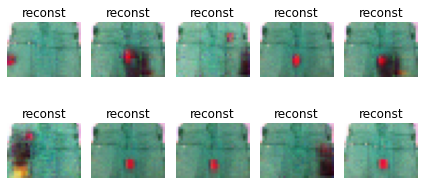

In [9]:
generate_xy_Image(model, data_input, fig_name="MSEepoch2000_z2_10e5_halfscale_weight.pth")

In [10]:
#data(50, 160, 2) -> return latent(160, 2)
def cal_step_meanlatent(data):
    z_mean_latent = torch.zeros(data.shape[1], 2)
    data = torch.from_numpy(data)

    for i in range(data.shape[1]):
        zs_step_mean = torch.mean(data[:, i, :], axis = 0).reshape([-1, 2])           
        z_mean_latent[i] = zs_step_mean

    return z_mean_latent#(160, 2)      


def cal_task_latent(model, image_data):
    device = 'cpu'
    
    image_data = image_data.reshape(image_data.shape[0]*image_data.shape[1], 3, 24, 32)
    model.eval()
    image_data = torch.from_numpy(image_data).float()
    image_data = image_data.to(device)
    with torch.no_grad():
        z_latent, _ = model.forward(image_data)#(16000, 2)

    z_latent_pca, explain_variance_ratio = pca(z_latent, n_components=2)
    
    left_task_z_pca = z_latent_pca[:int(z_latent_pca.shape[0]/2), :]#(8000, 2)
    right_task_z_pca = z_latent_pca[int(z_latent_pca.shape[0]/2) :, :]#(8000, 2)
    left_task_z_pca = left_task_z_pca.reshape(50, 160, 2)
    right_task_z_pca = right_task_z_pca.reshape(50, 160, 2)
    print("z_left_latent_pca")

    left_task_mean_latent = cal_step_meanlatent(left_task_z_pca)
    right_task_mean_latent = cal_step_meanlatent(right_task_z_pca)
    
    return left_task_mean_latent, right_task_mean_latent, explain_variance_ratio

def pca(z, n_components):
    pca = PCA(n_components).fit(z)
    return pca.fit_transform(z), pca.explained_variance_ratio_


#散布図にカラーマップ、ラベルをつけたりする
# https://python-academia.com/matplotlib-scatter/
#scatterとplotの二つを同時に適用できる
def visualize_2task_pca(left_pca,right_pca, explain_variance_ratio, fig_name):
    labels = [str(10*num) for num in range(1,int(left_pca.shape[0]/10)+1)]
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(left_pca[:, 0], left_pca[:, 1])
    ax.scatter(right_pca[:, 0], right_pca[:, 1])
    ax.plot(left_pca[:, 0], left_pca[:, 1])
    ax.plot(right_pca[:, 0], right_pca[:, 1])
    ax.set_xlabel("first_pricipal_component(variance_ratio : {})".format(explain_variance_ratio[0]))
    ax.set_ylabel("second_pricipal_component(variance_ratio : {})".format(explain_variance_ratio[1]))
    ax.legend(['left_task', 'right_task'])
    ax.set_title('pca')

    for i, label in enumerate(labels):
        ax.text(left_pca[10*i, 0], left_pca[10*i, 1],label)
        ax.text(right_pca[10*i, 0], right_pca[10*i, 1],label)
    plt.savefig(fig_name + ".png")

def visualize_2task_time_horizontal(task1_pca1, task_pca2, fig_name):
    fig = plt.figure()
    plt.subplots_adjust(hspace=0.6)

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_title("first_pricipal_component")
    ax1.set_xlim(0, 160)
    # ax1.scatter(task1_pca1[:, 0])
    # ax1.scatter(task_pca2[:, 0])
    ax1.plot(task1_pca1[:, 0])
    ax1.plot(task_pca2[:, 0])
    ax1.legend(['task1', 'task2'])

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_title("second_pricipal_component")
    ax2.set_xlim(0, 160)
    # ax2.scatter(task1_pca1[:, 1])
    # ax2.scatter(task_pca2[:, 1])
    ax2.plot(task1_pca1[:, 1])
    ax2.plot(task_pca2[:, 1])
    ax2.legend(['task1', 'task2'])

    plt.savefig(fig_name + "time_step.png")



z_left_latent_pca
z_left : torch.Size([160, 2])
z_right : torch.Size([160, 2])


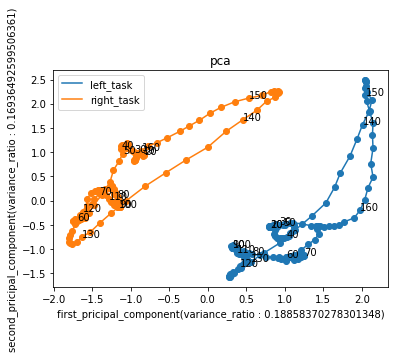

In [11]:
#それぞれのタスクの潜在表現を出力(160ステップ)

z_left_latent_pca, z_right_latent_pca, explain_variabce_ratio = cal_task_latent(model, data_narray.reshape(100,160, 3, 24, 32))
print("z_left : {}".format(z_left_latent_pca.shape))
print("z_right : {}".format(z_right_latent_pca.shape))


visualize_2task_pca(z_left_latent_pca,z_right_latent_pca,explain_variabce_ratio,"z_latent_z5")

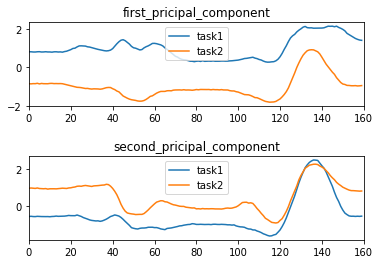

In [12]:
visualize_2task_time_horizontal(z_left_latent_pca, z_right_latent_pca, "z_latent_z5")